In [1]:
!pip install pygrib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.6/18.6 MB 20.7 MB/s eta 0:00:00


<ipython-input-26-3e8a6ffe97a1>:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['headwind_Phi_30'] = filtered_df.apply(lambda row: headwind_factor(row['wind_speed'], row['wind_direction'], 30, 20), axis=1)


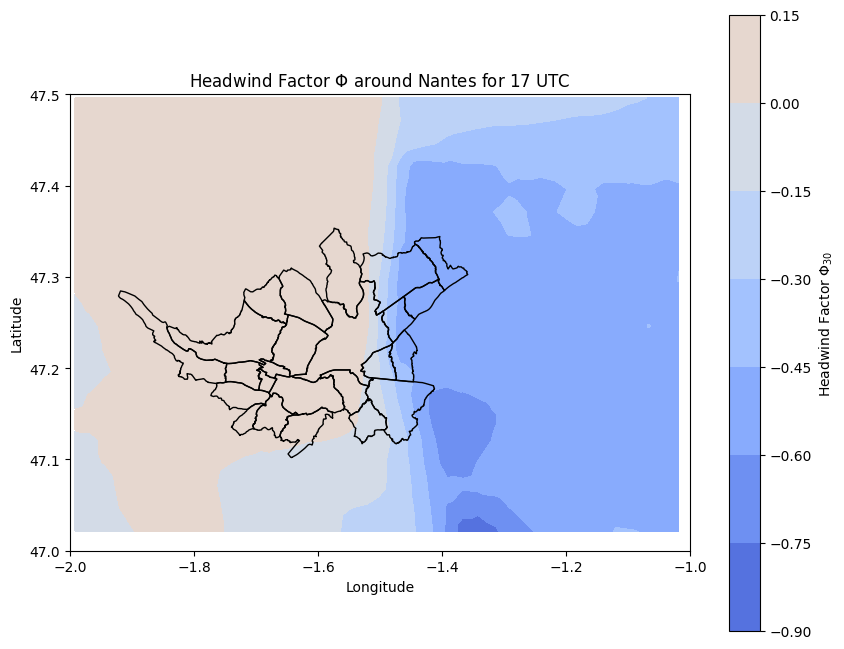

In [26]:
import pygrib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

import geopandas as gpd
from scipy.interpolate import griddata

def headwind_factor(wind_speed, wind_dir, drone_bearing, drone_airspeed):
  """
  Calculates the headwind factor (phi) for a drone considering wind speed, direction, bearing, and airspeed (assuming straight flight).

  Args:
      wind_speed: Wind speed in meters per second (m/s).
      wind_dir: Wind direction in degrees (0 deg = North, 90 deg = East).
      drone_bearing: Drone's bearing in degrees (0 deg = North, 90 deg = East).
      drone_airspeed: Drone's constant airspeed in meters per second (m/s).

  Returns:
      Headwind factor (phi) as a float.
  """

  # Handle cases where wind_dir or bearing is greater than 360
  wind_dir = wind_dir % 360
  bearing = drone_bearing % 360

  # Calculate the difference in angles
  theta = abs(wind_dir - bearing)

  # Handle cases where the difference is greater than 180
  if theta > 180:
    theta = 360 - theta

  # Calculate headwind component
  V_hw = wind_speed * math.cos(math.radians(theta))

  # Calculate headwind factor
  headwind_factor = V_hw / drone_airspeed

  return headwind_factor


# Step 1: Load the GRIB file
grib_file = '/content/arome_10m_NW_20170112000000.grib'

lat_min = 47.0
lat_max = 47.5
lon_min = -2.0
lon_max = -1.0

# Step 2: Open the GRIB file
grbs = pygrib.open(grib_file)

valid_time_of_interest = 1700
valid_date_of_interest = 20170112

data = {
    'param_name': [],
    'param_value': [],
    'Date': [],
    'time': [],
    'latitude': [],  # Add latitude
    'longitude': []  # Add longitude
}

# Loop through the messages to find the wind speed and wind direction for the specified time
for grb in grbs:
    if grb.validityTime == valid_time_of_interest and grb.validityDate == valid_date_of_interest:
        data['param_name'].append(grb['name'])
        data['param_value'].append(grb.values.ravel())
        data['Date'].append(grb.validityDate)
        data['time'].append(grb.validityTime)
        data['latitude'].append(grb['latitudes'].ravel())
        data['longitude'].append(grb['longitudes'].ravel())

# Close the GRIB file
grbs.close()

# Convert lists of arrays to single arrays for DataFrame construction
data['param_value'] = np.concatenate(data['param_value'])
data['latitude'] = np.concatenate(data['latitude'])
data['longitude'] = np.concatenate(data['longitude'])

# Replicate param_name, Date, and time to match the flattened arrays
num_points = len(data['latitude'])
data['param_name'] = np.repeat(data['param_name'], num_points // len(data['param_name']))
data['Date'] = np.repeat(data['Date'], num_points // len(data['Date']))
data['time'] = np.repeat(data['time'], num_points // len(data['time']))

df = pd.DataFrame(data)

# Display the DataFrame

u_wind_df = df[df['param_name'] == '10 metre U wind component']
v_wind_df = df[df['param_name'] == '10 metre V wind component']

# Ensure both dataframes have the same indices
u_wind_df = u_wind_df.reset_index(drop=True)
v_wind_df = v_wind_df.reset_index(drop=True)

# Calculate wind speed and wind direction
wind_speed = np.sqrt(u_wind_df['param_value']**2 + v_wind_df['param_value']**2)
wind_direction = (np.arctan2(-u_wind_df['param_value'], -v_wind_df['param_value']) * 180 / np.pi) % 360

# Create a new DataFrame with wind speed and wind direction
merged_df = pd.DataFrame({
    'Date': u_wind_df['Date'],
    'time': u_wind_df['time'],
    'latitude': u_wind_df['latitude'],
    'longitude': u_wind_df['longitude'],
    'wind_speed': wind_speed,
    'wind_direction': wind_direction
})


# Cut the area to the specified bounds
llat_min = 47.0
lat_max = 47.5
lon_min = -2.0
lon_max = -1.0

filtered_df = merged_df[
    (merged_df['latitude'] >= lat_min) &
    (merged_df['latitude'] <= lat_max) &
    (merged_df['longitude'] >= lon_min) &
    (merged_df['longitude'] <= lon_max)
]


#Calculate Headwind Factor
filtered_df['headwind_Phi_30'] = filtered_df.apply(lambda row: headwind_factor(row['wind_speed'], row['wind_direction'], 30, 20), axis=1)

# Create a grid for interpolation
lon_grid = np.linspace(lon_min, lon_max, 500)
lat_grid = np.linspace(lat_min, lat_max, 500)
lon_mesh, lat_mesh = np.meshgrid(lon_grid, lat_grid)

# Interpolate the headwind factor values onto the grid
grid_headwind = griddata(
    (filtered_df['longitude'], filtered_df['latitude']),
    filtered_df['headwind_Phi_30'],
    (lon_mesh, lat_mesh),
    method='linear'
)

# Load the city boundaries shapefile
city_boundaries = gpd.read_file('244400404_communes-nantes-metropole.shp')

#Define cmap
# Define colormap and normalization centered at zero
cmap = plt.get_cmap('coolwarm')

# Plotting
plt.figure(figsize=(10, 8))
sc = plt.contourf(lon_mesh, lat_mesh, grid_headwind, cmap=cmap, vmax = 1, vmin = -1)
plt.colorbar(sc, label='Headwind Factor $\Phi_{30}$')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f'Headwind Factor $\Phi$ around Nantes for {valid_time_of_interest//100} UTC')

# Overlay the city boundaries
city_boundaries.boundary.plot(ax=plt.gca(), color='black', linewidth=1)

plt.savefig(f'Headwind_30_{valid_time_of_interest}.png')
plt.savefig(f'Headwind_30_{valid_time_of_interest}.pdf')
plt.show()